Original Image


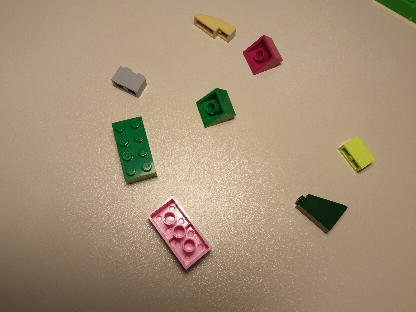

Final Edges Image


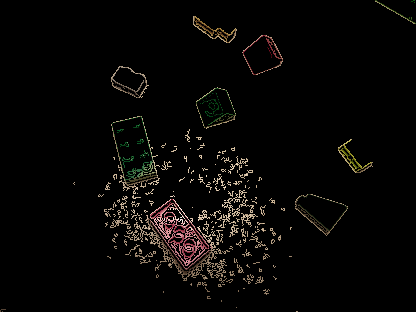

Contours of the Edges


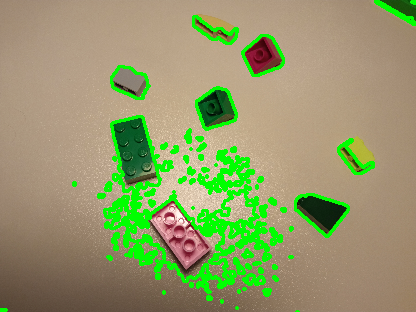

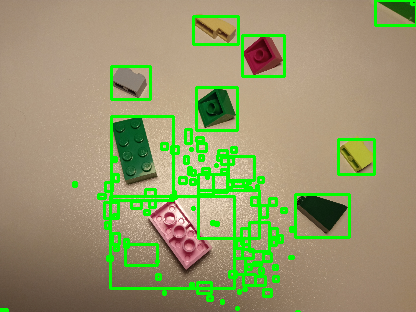

Detected too many bounding boxes, using kmeans again to reduce noise.
Final Edges Image


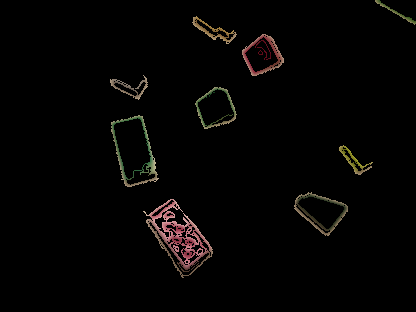

Contours of the Edges


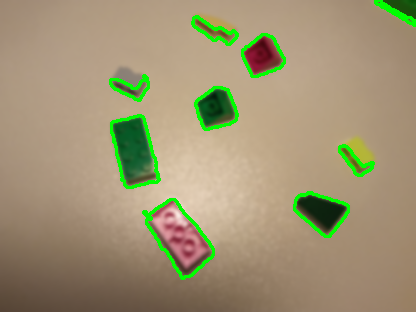

Bounding Boxes: 9


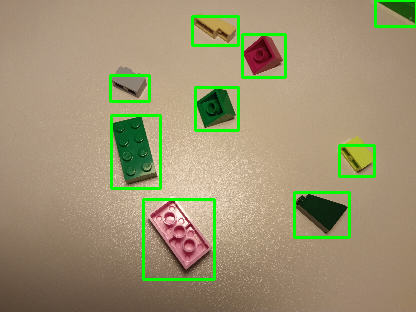


================== Color Extraction ==================



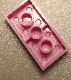

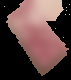

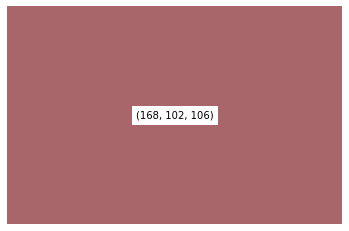

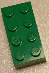

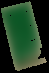

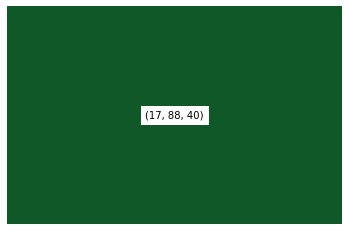

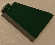

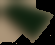

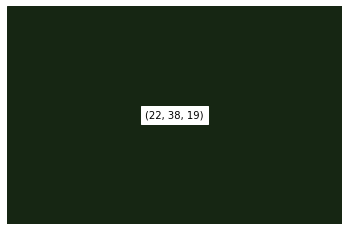

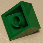

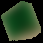

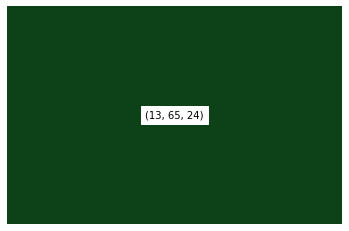

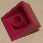

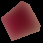

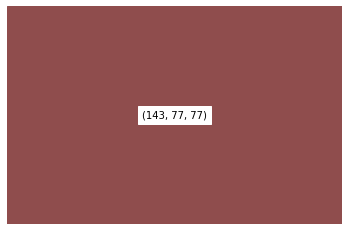

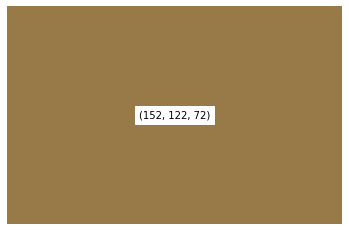

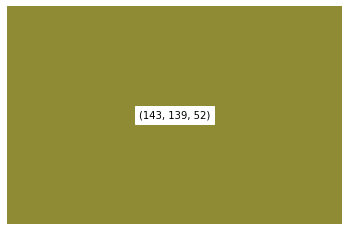

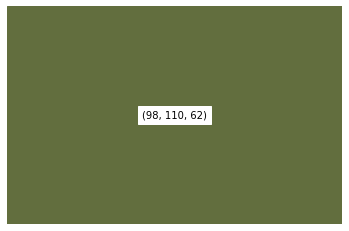

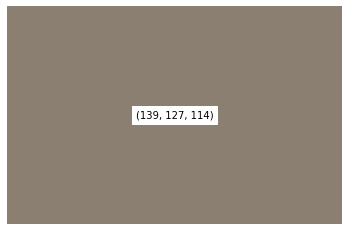

Colors list: 
(168, 102, 106)	(17, 88, 40)	(22, 38, 19)	(13, 65, 24)	(143, 77, 77)	(152, 122, 72)	(143, 139, 52)	(139, 127, 114)	



In [1]:
# ======================== Imports ========================

import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, Image
import os
import json
import sys

# ======================== Suppress Warnings ========================

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ======================== Global Model Parameters ========================

debug = True
imgLoadSizeRatio = 0.1
dataDir = 'imgs'

# Contours Configurations
kmeansBlurQuantity = 1
kmeansClusterSize = 8
cannyThreshold1 = 110
cannyThreshold2 = 200
numEdgeIterations = 10
contourConnectSize = 2

# Bounding Box Configurations
manyBBThreshold = 15
blurQntManyBB = 9
boundingBoxMinPossibleArea = 200
boundingBoxMaxPossibleAreaRatio = 0.3
boundingBoxIntersectionThreshold = 0.25

# BB Color Configurations
bbColorBlurQnt = 31
bbColorClusterSize = 8
sameColorDistanceThreshold = 45

# ======================== Image Display Functions ========================

def loadImage(num):
    global imgLoadSizeRatio, dataDir
    img = cv2.imread(os.path.join(dataDir, f'{num}.jpg'))
    img = cv2.resize(img, (0, 0), fx = imgLoadSizeRatio, fy = imgLoadSizeRatio)
    return img


def render(image):
    images = [image]
    for i in range(len(images)):
        if images[i].dtype == np.float64:
            image = cv2.convertScaleAbs(images[i])
        else:
            image = images[i]
        if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
            if np.array_equal(image[:, :, 0], image[:, :, 2]):
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_bytes = cv2.imencode('.png', image)[1].tobytes()
        display(Image(data=img_bytes))

# ======================== Image Pre-Processing ========================

# Gaussian Blur + K-means clustering to get color regions
def kmeansBlur(img, kmeansBlurQuantity, kmeansClusterSize):
    blurred = cv2.GaussianBlur(img, (kmeansBlurQuantity, kmeansBlurQuantity), 0)
    
    pixels = blurred.reshape((-1, 3))
    pixels = np.float32(pixels)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 1.0)
    _, labels, centers = cv2.kmeans(pixels, kmeansClusterSize, None, criteria, 12, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_data = centers[labels.flatten()]
    segmented_image = segmented_data.reshape((img.shape))
    
    return segmented_image    


# Draw edges on image using a mask
def drawEdgeImg(img, edges):
    edge_mask = np.zeros_like(img)
    edge_mask[edges > 0] = (255, 255, 255)
    edge_image = cv2.bitwise_and(img, edge_mask)
    render(edge_image)


# Get the edges of the image with Canny edge detection
def getEdges(img):
    global cannyThreshold1, cannyThreshold2
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, cannyThreshold1, cannyThreshold2)
    return edges


# Get the contours of the edges in the image
def getContours(img, edges):
    global contourConnectSize
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (contourConnectSize, contourConnectSize))
    dilated_edges = cv2.dilate(edges, kernel)
    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_image = img.copy()
    cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)
    return contour_image, contours


# Apply pre-processing to the image to get the contours and extract lego contours
def preprocessImg(img):
    global numEdgeIterations, kmeansBlurQuantity, kmeansClusterSize, contourConnectSize, debug
    
    edge_sum = np.zeros(img.shape[:2])
    
    for i in range(numEdgeIterations):
        segmented_img = kmeansBlur(img, kmeansBlurQuantity, kmeansClusterSize + i)    
        new_edges = getEdges(segmented_img)
        edge_sum += new_edges

    # Threshold the accumulated edges so that at least 1/2 of iterations agree
    edges = (edge_sum >= (numEdgeIterations / 2)).astype(np.uint8) * 255

    if debug:
        print("Final Edges Image")
        drawEdgeImg(img, edges)
        
    contour_image, contours = getContours(img, edges)
    
    if debug:
        print("Contours of the Edges")
        render(contour_image)
        
    return contours

# ======================== Bounding Box Processing ========================

# Check if two bounding boxes overlap more than a certain threshold
def checkIfBBOverlap(bb1, bb2):
    global boundingBoxIntersectionThreshold
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    intersection_area = max(0, min(x1+w1, x2+w2) - max(x1, x2)) * max(0, min(y1+h1, y2+h2) - max(y1, y2))
    union_area = w1 * h1 + w2 * h2 - intersection_area
    return intersection_area / union_area > boundingBoxIntersectionThreshold


# Check if bb1 is contained within bb2
def checkIfBBContained(bb1, bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    return x1 >= x2 and y1 >= y2 and x1 + w1 <= x2 + w2 and y1 + h1 <= y2 + h2


# Remove contained bounding boxes
def remove_contained_rectangles(bounding_rectangles):

    if len(bounding_rectangles) < 2:
        return bounding_rectangles
    
    rectangles_to_remove = []

    # Iterate through each pair of bounding boxes
    for i in range(len(bounding_rectangles)):
        for j in range(i + 1, len(bounding_rectangles)):
            
            try:
                bb1 = bounding_rectangles[i]
                bb2 = bounding_rectangles[j]

                # Check if one bounding box is contained within the other
                if checkIfBBContained(bb1, bb2):
                    rectangles_to_remove.append(i)
                elif checkIfBBContained(bb2, bb1):
                    rectangles_to_remove.append(j)
            except:
                continue

    # Remove the contained rectangles
    bounding_rectangles = [bb for i, bb in enumerate(bounding_rectangles) if i not in rectangles_to_remove]
    return bounding_rectangles


# Remove overlapping bounding boxes
def remove_overlapping_rectangles(bounding_rectangles):

    if len(bounding_rectangles) < 2:
        return bounding_rectangles
    
    # Iterate through each pair of bounding boxes
    for i in range(len(bounding_rectangles)):
        for j in range(i + 1, len(bounding_rectangles)):
            
            try:
                bb1 = bounding_rectangles[i]
                bb2 = bounding_rectangles[j]

                # Check if the bounding boxes overlap more than the threshold
                if checkIfBBOverlap(bb1, bb2):
                    
                    # Remove the smallest bounding box of the pair
                    if bb1[2] * bb1[3] < bb2[2] * bb2[3]:
                        bounding_rectangles.remove(bb1)
                    else:
                        bounding_rectangles.remove(bb2)
            except:
                continue

    return bounding_rectangles


# Get the bounding boxes for the legos based on the contours edges, removing possible false matches
def getBoundingBoxes(img, contours):
    
    global boundingBoxMinPossibleArea, blurQntManyBB, manyBBThreshold, debug
    
    num_legos = 0
    bounding_box_image = img.copy()
    bounding_rectangles = []

    temp = bounding_box_image.copy()
    counter = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(temp, (x, y), (x + w, y + h), (0, 255, 0), 2)
        counter += 1
    
    if debug:
        render(temp)
    
    if counter > manyBBThreshold:
        if debug:
            print("Detected too many bounding boxes, using kmeans again to reduce noise.")
        blurred = cv2.GaussianBlur(img, (blurQntManyBB, blurQntManyBB), 0)
        contours = preprocessImg(blurred)
    
    for contour in contours:
        
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        
        # Ignore small area rectangles because they are likely noise
        if area < boundingBoxMinPossibleArea:
            continue
        
        # Ignore large area rectangles because they are likely to be the entire image
        if area > boundingBoxMaxPossibleAreaRatio * img.shape[0] * img.shape[1]:
            continue
        
        bounding_rectangles.append((x, y, w, h))
        
    # Sort the bounding boxes by area in descending order
    bounding_rectangles = sorted(bounding_rectangles, key=lambda x: x[2] * x[3], reverse=True)

    # Remove bounding boxes that are contained within other bounding boxes
    bounding_rectangles = remove_contained_rectangles(bounding_rectangles)

    # Check each bb pair and remove the smallest of the pair if they overlap more than threshold
    bounding_rectangles = remove_overlapping_rectangles(bounding_rectangles)
    
    # Draw the bounding boxes on the image
    for x, y, w, h in bounding_rectangles:
        cv2.rectangle(bounding_box_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        num_legos += 1
        
    if debug:
        print("Bounding Boxes: " + str(num_legos))
        render(bounding_box_image)
        
    return num_legos, bounding_rectangles

# ======================== BB Color Extraction ========================

# Get the image contained in a bounding box
def getBoundingBoxImage(img, box):
    x, y, w, h = box
    cropped_image = img[y:y+h, x:x+w]
    return cropped_image


# Display a square of a specific color in RGB format
def display_color_square(color):
    color = (color[0] / 255, color[1] / 255, color[2] / 255)
    _, ax = plt.subplots()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    rectangle = plt.Rectangle((0, 0), 1, 1, color=color)
    ax.add_patch(rectangle)
    name = f"({color[0] * 255:.0f}, {color[1] * 255:.0f}, {color[2] * 255:.0f})"
    ax.text(0.5, 0.5, name, ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='white'))
    ax.axis('off')
    plt.show()   


# Take advantage of LAB color space to compare colors more accurately than RGB
def are_colors_same(color1, color2):
    global sameColorDistanceThreshold
    
    # Convert colors to LAB color space
    color1_lab = cv2.cvtColor(np.uint8([[color1]]), cv2.COLOR_RGB2LAB)[0][0]
    color2_lab = cv2.cvtColor(np.uint8([[color2]]), cv2.COLOR_RGB2LAB)[0][0]

    # Calculate Euclidean distance between colors in LAB space
    distance = np.linalg.norm(color1_lab - color2_lab)

    return distance < sameColorDistanceThreshold

# Returns the foreground mask, which will be used to extract the lego color
def getGrabCutMask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, img.shape[1] - 1, img.shape[0] - 1)
    cv2.grabCut(img, mask, rect, bgModel, fgModel, 5, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return mask 


# Get the color of the lego piece
def getLegoColor(lego_img):
    global bbColorBlurQnt, bbColorClusterSize, debug
    
    # Apply K-means clustering to reduce the number of colors
    try:
        pixels = lego_img.reshape((-1, 3))
        kmeans_all = KMeans(n_clusters=bbColorClusterSize, n_init=10, max_iter=300, tol=1e-4, random_state=0)
        kmeans_all.fit(pixels)
        lego_img_kmeans = kmeans_all.cluster_centers_[kmeans_all.labels_].reshape(lego_img.shape).astype(np.uint8)
        lego_img = lego_img_kmeans
    except:
        print("Failed to reduce the color space for lego color extraction")
        
    fg_mask = getGrabCutMask(lego_img)
    
    # Apply a blur to the image to reduce noise
    lego_img_blurred = cv2.GaussianBlur(lego_img, (bbColorBlurQnt, bbColorBlurQnt), 0)

    # Mask out the background
    fg_pixels = lego_img_blurred[np.where(fg_mask == 1)]
    
    # Masked image
    if debug:
        temp = cv2.bitwise_and(lego_img_blurred, lego_img_blurred, mask=fg_mask)
        render(temp)
        
    # Apply k-means clustering to get the most common color
    try:
        kmeans = KMeans(n_clusters=bbColorClusterSize, n_init=10, max_iter=300, tol=1e-4, random_state=0)
        kmeans.fit(fg_pixels)
        most_common_color = Counter(kmeans.labels_).most_common(1)[0][0]
        color = kmeans.cluster_centers_[most_common_color].astype(np.uint8)
    except:
        # if k-mean fails for some reason, like the grab cut deleting everything
        print("K-means clustering failed to extract lego color")
        # Use default color: white
        color = np.array([255, 255, 255], dtype=np.uint8) 
    
    color_rgb = color[..., ::-1] # Convert BGR to RGB
 
    return color_rgb

# Get the bounding box lego color
def getBBColor(og_img, box):
    
    global debug
  
    # Extract the bounding box image from the original image
    lego_img = getBoundingBoxImage(og_img, box)
    
    if debug:
        render(lego_img)
    
    # Get the most common color in the bounding box image, which should be the color of the lego
    color = getLegoColor(lego_img)
    
    # Display the extracted color
    if debug:
        try:
            display_color_square(color)
        except:
            print("No color was found for this lego piece.")
            color = (0, 0, 0)
        
    return color


# Get Number of Different Lego Colors
def getNumDifferentColors(og_img, boxes):
    colors = []
    
    for box in boxes:
        color = getBBColor(og_img, box)
        similar_color_found = False

        for recorded_color in colors:
            if are_colors_same(color, recorded_color):
                similar_color_found = True
                break
            
        if not similar_color_found:
            colors.append(color)
        
    return len(colors), colors

# ======================== Guess Lego Count & Color ========================

# Evaluate results for lego counting
def getActualPieceCount(imgID):
    df = pd.read_csv("lego_sets.csv")
    piece_count = df.loc[df['id'] == imgID, 'piece_count'].values[0]
    return piece_count 

# Guess the number of lego colors
def getActualColorCount(imgID):
    df = pd.read_csv("lego_sets.csv")
    color_arr = df.loc[df['id'] == imgID, 'piece_colors'].values[0]
    color_count = color_arr.count("-") + 1
    return color_count 

# ======================== Main Model Definition ========================

# the model itself
def model(image_id, inputMode = False):
    
    global debug
    
    # Load the image
    if inputMode:
        pass
    else:
        og_img = loadImage(image_id)
    
    if debug:
        print("Original Image")
        render(og_img)
    
    # contours the image to extract the edges and contours
    contours = preprocessImg(og_img)
    
    # Bounding box evaluation
    num_legos_guess, boxes = getBoundingBoxes(og_img, contours)
            
    # Color evaluation
    if debug:
        print("\n================== Color Extraction ==================\n")
    num_colors_guess, color_list = getNumDifferentColors(og_img, boxes)
    
    if debug:
        print("Colors list: ")
        for c in color_list:
            print(f"({c[0]}, {c[1]}, {c[2]})", end="\t")
        print("\n")
        
    return num_legos_guess, num_colors_guess, boxes

# ======================== Model Evaluation ========================

# guesses number of legos and colors for a specific image
def makeGuess(image_id, num_legos_guess, num_colors_guess):
    global debug
    
    # Make the guesses
    piece_count = getActualPieceCount(image_id)
    color_count = getActualColorCount(image_id)
        
    # Calculate error
    num_legos_error = abs(num_legos_guess - piece_count)
    num_colors_error = abs(num_colors_guess - color_count)
    
    if debug:
        if(num_legos_error > 0):
            print(f"Error in Lego Count - Guessed: {num_legos_guess} | Actual: {piece_count} legos")
        if(num_colors_error > 0):
            print(f"Error in Lego Color - Guessed: {num_colors_guess} | Actual: {color_count} colors")
        if num_legos_error == 0 and num_colors_error == 0:
            print("Perfect guess!")
    
    return num_legos_error, num_colors_error, piece_count, color_count


# evaluate model performance on all 50 images of the dataset
def evaluate_model():
    
    total_lego_error = 0
    total_color_error = 0
    total_lego = 0
    total_color = 0
    error_count_ids = []
    error_colors_ids = []
    
    for i in range(0, 50):
        print(f"\n======================== Image {i} ========================\n")
        num_legos_guess, num_colors_guess, _ = model(i)
        num_legos_error, num_colors_error, piece_count, color_count = makeGuess(i, num_legos_guess, num_colors_guess)
        
        if(num_legos_error > 0):
            error_count_ids.append(i)
        if(num_colors_error > 0):
            error_colors_ids.append(i)

        total_lego_error += num_legos_error
        total_color_error += num_colors_error
        total_lego += piece_count
        total_color += color_count
    
    error_count_ids = set(error_count_ids)
    error_colors_ids = set(error_colors_ids)
    
    print(f"\n\n======================== TOTAL RESULTS ========================")   
    print(f"Total Lego Error: {total_lego_error} | {total_lego}")
    print(f"Total Color Error: {total_color_error} | {total_color}")
    print("Num of images with count errors: " + str(len(error_count_ids)))
    print("Error images: " + str(error_count_ids))
    print("Num of images with count errors: " + str(len(error_colors_ids)))
    print("Error images: " + str(error_colors_ids))
    print("===============================================================")
    
# ======================== Main ========================

# evaluate_model()
num_legos_guess, num_colors_guess, boxes = model(11)